### Prioritized Experience Replay
- agent는 기존 DQN/Double DQN과 동일
- 다만, replay buffer 저장하고 sampling하는 방식에서 차이를 보인다.
- 어떻게 저장되는 transition의 우선순위를 정할 것인가에 집중하여 진행

In [48]:
import sys
import gym
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms

from IPython.display import clear_output

env = gym.make('CartPole-v0').unwrapped

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
# state, action shape 확인
print("state shape : ",env.observation_space.shape)
print("# of action : ",env.action_space.n)

state shape :  (4,)
# of action :  2


In [44]:
# 셋팅은 DQN과 동일

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
env = gym.make('CartPole-v0')
env = env.unwrapped # ??
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
# isinstance : action_space의 sample action의 type이 int인가? True or False return
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape 

In [36]:
# network setting
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(N_STATES, 24)
        self.l1.weight.data.normal_(0, 0.1)
        self.l2 = nn.Linear(24, 24)
        self.l2.weight.data.normal_(0 ,0.1)
        self.out = nn.Linear(24, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [12]:
# agent setting
class DQN:
    def __init__(self):
        # 먼저 prediction network와 target network 분리
        self.pred_net, self.target_net = Net(), Net()
        
        self.learn_step_counter = 0 # for target updating
        self.memory_counter = 0 # for storing memory
        # (capacity, 4) ; 4 = (state, action, reward, next_state)
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))
        self.optimizer = torch.optim.Adam(self.pred_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss() # 이러면 알아서 y와 y_hat을 인식하나??
        
    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), dim=0) # (1, ?)
        # 1. greedy 
        if np.random.uniform() < EPSILON: # EPSILON = 0.9
            actions_value = self.pred_net.forward(x)
            # [1]은 return값중 argmax를 받겠다는 의미
            # max의 return값이 max, argmax 두개가 나옴
            # .data까지는 print해주는 output의 변화없고 이걸 numpy로 변환
            action = torch.max(actions_value, dim=1)[1].data.numpy()
            # 아래가 뭘 의미하는 거지...
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        
        # random
        else:
            action = np.random.randint(0, N_ACTIONS) # 0,1중에 하나 선택
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        
        return action
    
    def store_transition(self, state, action, reward, next_state):
        # state가 list/array이기때문에, action과 reward를 []로 묶어준다.
        # **state가 4가지 정보를 담고있다.
        transition = np.hstack([state, [action,reward], next_state])
        # replace the old memory with new memory
        idx = self.memory_counter % MEMORY_CAPACITY
        self.memory[idx,:] = transition
        self.memory_counter += 1
        
    def learn(self):
        # TARGET_REPLACE_ITER은 100으로 설정했다.
        # 이 말은 즉 target network를 100번에 한번씩 업데이트하겠다는 의미
        # pred_net 100번 업데이트하고 나서야 비로소 target_net 1번 업데이트
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            # target의 parameter를 pred_net의 parameter로 대체하겠다는 의미
            self.target_net.load_state_dict(self.pred_net.state_dict())
            
        self.learn_step_counter += 1
        
        # batch transition sampling
        sample_idx = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_idx, :]
        b_state = torch.FloatTensor(b_memory[:, :N_STATES])
        b_action = torch.LongTensor(b_memory[:, N_STATES : N_STATES+1].astype(int)) # long 이어야함 (Integer)
        b_reward = torch.FloatTensor(b_memory[:, N_STATES+1 : N_STATES+2])
        b_next_state = torch.FloatTensor(b_memory[:, -N_STATES:])
        
        q_pred = self.pred_net(b_state).gather(1, b_action) # gather의 의미를 모르겠다..
        q_prime = self.target_net(b_next_state).detach() # detach from graph, don't backpropagate(gradient가 흘러들어가 업데이트 되지않도록 예방)
        q_target = b_reward + GAMMA * q_prime.max(dim=1)[0].view(BATCH_SIZE,1) # shape (batch, 1)
        loss = self.loss_func(q_pred, q_target)
        
        self.optimizer.zero_grad() # gradient initialize
        loss.backward()
        self.optimizer.step()
print("Get Ready for Training!!")

Get Ready for Training!!


In [6]:
# # prioritized replay memory 
# class PER:
#     def __init__(self, alpha, beta):
#         self.alpha = alpha # alpha in prioritization computation
#         self.beta = beta # beta in importance sampling weight computation
        

---

In [1]:
import sys
import gym
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms

from IPython.display import clear_output

### Prioritized Experience Replay
- 주찬웅님 github 발췌 : [주찬웅님 github링크](https://github.com/rlcode/per/blob/master/SumTree.py)
- replay memory를 어떻게 정렬할 것인가?
- heap sort(힙 정렬)의 개념이 들어감 : [heap sort 개념링크](https://github.com/Junhojuno/Lets-RL/blob/master/code/cartpole/heapSort.md)

In [2]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity # capacity는 memory_size를 의미
        
        # 1D array (완전이진트리)
        # 왜 2*capacity - 1인가? --> 아마 정렬시 root node와 leaf node를 맞바꾸기 위함인가? 미리 늘려주는건가?
        self.tree = np.zeros(2 * capacity - 1) 
        
        # 이건 뭐지?
        self.data = np.zeros(capacity, dtype=object)
        
        # entries setting (initialize)
        self.n_entries = 0

    # update to the root node
    # root index까지 key값을 더한다.
    # 그리고 해당 idx의 부모노드에 idx의 p값이 변화한 정도를 반영해주는 함수다.
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2 # parent node 구하려면 해당 노드를 2로 나눠주는건데 -1은 왜 한거지?

        self.tree[parent] += change

        if parent != 0: # root node가 아니면 다시 parent node구한다.
            self._propagate(parent, change)

    # find sample on leaf node
    # leaf index를 뽑는다.
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = 2 * idx + 2 # left + 1과 동일한 값

        if left >= len(self.tree): # left index값이 dataset의 길이보다 크거나 같으면
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else: # s > tree[left]
            return self._retrieve(right, s - self.tree[left])

    # total이 왜 tree[0]값이지?
    # total이라는게 TD error의 총값이고 그게 node의 key값이고
    # 이 값은 root node의 key값이 된다.(그래서 위에서 += change해줌)
    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1 # 첫 시작은 가장 마지막 인덱스 ex) 20000의 capacity라면 idx=19999

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    # p값이 바뀌면 해당 idx와 그 idx의 부모노드에 까지 변화량을 반영해주겠다는 의미
    def update(self, idx, p): # 해당 idx의 priority를 p값으로 바꾸겠다
        change = p - self.tree[idx] # 새로운 p와 기존에 idx가 가지고 있던 p의 차이 (p의 변화량)
        self.tree[idx] = p # 해당 idx에 새로운 p를 넣고
        self._propagate(idx, change) # 부모 노드에 동일하게 p의 변화량을 반영해줘서 자식 노드 값의 합은 부모노드의 값과 같다는 조건을 유지한다.

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        """
        def _retrieve(self, idx, s):
            left = 2 * idx + 1
            right = 2 * idx + 2 # left + 1과 동일한 값

            if left >= len(self.tree): # left index값이 dataset의 길이보다 크거나 같으면
                return idx

            if s <= self.tree[left]:
                return self._retrieve(left, s)
            else: # s > tree[left]
                return self._retrieve(right, s - self.tree[left])
        
        """
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [3]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    # p = |error| + epsilon 계산
    def _get_priority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error) # p 구하고
        self.tree.add(p, sample)

    # n = batch size (아래에 그렇게 들어감..)
    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n # ?
        priorities = [] # prioritiy score : p set

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)

episode: 60   score: 33.0   memory length: 1452   epsilon: 0.9103059999999857


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in power
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


ValueError: all the input array dimensions except for the concatenation axis must match exactly

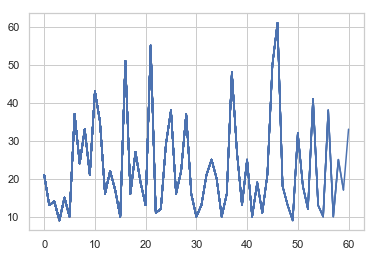

In [4]:
EPISODES = 500

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_size)
        )

    def forward(self, x):
        return self.fc(x)


# DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and prioritized experience replay memory & target q network
class DQNAgent():
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.memory_size = 20000
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.explore_step = 5000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.batch_size = 64
        self.train_start = 1000

        # create prioritized replay memory using SumTree
        self.memory = Memory(self.memory_size)

        # create main model and target model
        self.model = DQN(state_size, action_size)
        self.model.apply(self.weights_init)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.learning_rate)

        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model = torch.load('save_model/cartpole_dqn')

    # weight xavier initialize
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            torch.nn.init.xavier_uniform(m.weight)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.from_numpy(state)
            state = Variable(state).float().cpu()
            q_value = self.model(state)
            _, action = torch.max(q_value, 1)
            return int(action)

    # save sample (error,<s,a,r,s'>) to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        target = self.model(Variable(torch.FloatTensor(state))).data
        old_val = target[0][action]
        target_val = self.target_model(Variable(torch.FloatTensor(next_state))).data
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.discount_factor * torch.max(target_val)

        error = abs(old_val - target[0][action])

        self.memory.add(error, (state, action, reward, next_state, done))

    # pick samples from prioritized replay memory (with batch_size)
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch, idxs, is_weights = self.memory.sample(self.batch_size)
        mini_batch = np.array(mini_batch).transpose()

        states = np.vstack(mini_batch[0])
        actions = list(mini_batch[1])
        rewards = list(mini_batch[2])
        next_states = np.vstack(mini_batch[3])
        dones = mini_batch[4]

        # bool to binary
        dones = dones.astype(int)

        # Q function of current state
        states = torch.Tensor(states)
        states = Variable(states).float()
        pred = self.model(states)

        # one-hot encoding
        a = torch.LongTensor(actions).view(-1, 1)

        one_hot_action = torch.FloatTensor(self.batch_size, self.action_size).zero_()
        one_hot_action.scatter_(1, a, 1)

        pred = torch.sum(pred.mul(Variable(one_hot_action)), dim=1)

        # Q function of next state
        next_states = torch.Tensor(next_states)
        next_states = Variable(next_states).float()
        next_pred = self.target_model(next_states).data

        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Q Learning: get maximum Q value at s' from target model
        target = rewards + (1 - dones) * self.discount_factor * next_pred.max(1)[0]
        target = Variable(target)

        # |error| or |delta|를 의미
        errors = torch.abs(pred - target).data.numpy()

        # update priority
        for i in range(self.batch_size):
            idx = idxs[i]
            self.memory.update(idx, errors[i])

        self.optimizer.zero_grad()

        # MSE Loss function
        loss = F.mse_loss(pred, target)
        loss.backward()

        # and train
        self.optimizer.step()


if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    model = DQN(state_size, action_size)

    agent = DQNAgent(state_size, action_size)
    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)
            
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -10

            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if agent.memory.tree.n_entries >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                score = score if score == 500 else score + 10
                scores.append(score)
                episodes.append(e)
                plt.plot(episodes, scores, 'b')
                plt.savefig("./save_graph/cartpole_dqn.png")
                clear_output()
                print("episode:", e, "  score:", score, "  memory length:",
                      agent.memory.tree.n_entries, "  epsilon:", agent.epsilon)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    torch.save(agent.model, "./save_model/cartpole_dqn")
                    sys.exit()

- heap sort를 기반으로한 sum tree방식으로 transitions들을 정렬하였다.
- 그러기 위해 기존의 (s,a,r,s')외에 error가 추가로 memory구성에 들어갔다.
- error를 구하는 방식은 논문에 나온 그대로(p = |error| + epsilon)